In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import kagglehub
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import keras

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Pytorch

In [18]:
base_dir = r"C:\Users\joao_\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1\training_set\training_set"
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")

In [19]:
class CatDogDataset(Dataset):
    def __init__(self, cats_dir, dogs_dir, transform=None):
        self.cats_files = [os.path.join(cats_dir, f) for f in os.listdir(cats_dir)]
        self.dogs_files = [os.path.join(dogs_dir, f) for f in os.listdir(dogs_dir)]
        self.all_files = self.cats_files + self.dogs_files
        self.labels = [0] * len(self.cats_files) + [1] * len(self.dogs_files)
        self.transform = transform

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path = self.all_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CatDogDataset(cats_dir, dogs_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"train_dataset: {len(train_dataset)} - val_dataset: {len(val_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train_dataset: 6404 - val_dataset: 1601


In [35]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.ln_1 = nn.Linear(64 * 28 * 28, 256)
        self.ln_2 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = self.pool(F.relu(self.conv_3(x)))
        
        x = x.view(-1, 64 * 28 * 28)
        x = self.ln_1(x)
        x = self.ln_2(x)
        
        return x

In [53]:
def train_model(model, criterion, optimizer, epochs=5, device='cpu'):
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, label in train_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(train_dataset)
    
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

SimpleCNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ln_1): Linear(in_features=50176, out_features=256, bias=True)
  (ln_2): Linear(in_features=256, out_features=2, bias=True)
)

In [55]:
train_model(model, criterion, optimizer, 15, 'cuda')

Epoch 1/15, Loss: 0.6929, Validation Accuracy: 62.90%
Epoch 2/15, Loss: 0.5592, Validation Accuracy: 71.08%
Epoch 3/15, Loss: 0.4939, Validation Accuracy: 69.14%
Epoch 4/15, Loss: 0.4380, Validation Accuracy: 72.45%
Epoch 5/15, Loss: 0.3759, Validation Accuracy: 73.39%
Epoch 6/15, Loss: 0.3221, Validation Accuracy: 73.39%
Epoch 7/15, Loss: 0.2576, Validation Accuracy: 73.14%
Epoch 8/15, Loss: 0.1863, Validation Accuracy: 72.95%
Epoch 9/15, Loss: 0.1475, Validation Accuracy: 72.08%
Epoch 10/15, Loss: 0.0966, Validation Accuracy: 71.96%
Epoch 11/15, Loss: 0.1082, Validation Accuracy: 71.21%
Epoch 12/15, Loss: 0.0792, Validation Accuracy: 71.89%
Epoch 13/15, Loss: 0.0837, Validation Accuracy: 69.96%
Epoch 14/15, Loss: 0.0394, Validation Accuracy: 71.39%
Epoch 15/15, Loss: 0.0587, Validation Accuracy: 69.77%


In [59]:
def inference(model, image, transform=None, device='cpu'):
    model.to(device)
    model.eval()

    if isinstance(image, str):
        image = Image.open(image).convert('RGB')

    if not isinstance(image, torch.Tensor):
        if transform is None:
            # Default transform if none provided
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        image = transform(image)

    if image.dim() == 3:
        image = image.unsqueeze(0)

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item(), probabilities[0]

Predicted class: cat
Class probabilities: tensor([0.9649, 0.0351])


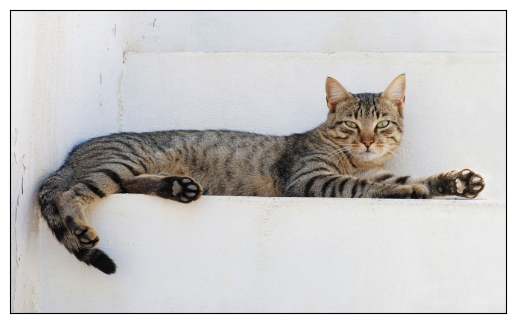

In [64]:
img = Image.open(r"C:\Users\joao_\Downloads\Cat_August_2010-4.jpg")

fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

pred_class, probs = inference(model, img)
print(f'Predicted class: {"cat" if pred_class == 0 else "dog"}')
print(f'Class probabilities: {probs}')

Predicted class: dog
Class probabilities: tensor([0.0033, 0.9967])


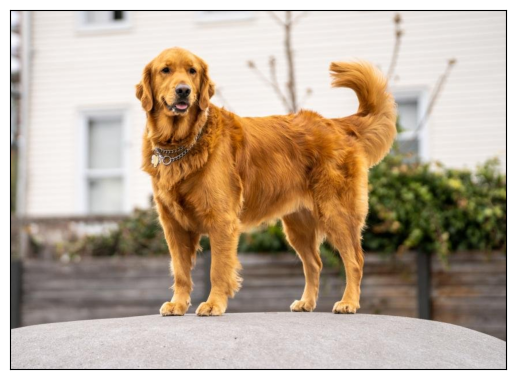

In [65]:
img = Image.open(r"C:\Users\joao_\Downloads\Golden+Retrievers+dans+pet+care.jpeg")

fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

pred_class, probs = inference(model, img)
print(f'Predicted class: {"cat" if pred_class == 0 else "dog"}')
print(f'Class probabilities: {probs}')

# Keras

In [2]:
path = kagglehub.dataset_download("tongpython/cat-and-dog")

cats_dir = r"C:\Users\joao_\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1\training_set\training_set\cats"
dogs_dir = r"C:\Users\joao_\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1\training_set\training_set\dogs"

training_dir = os.path.dirname(cats_dir)

print(f"Cat images: {len(os.listdir(cats_dir))}")
print(f"Dog images: {len(os.listdir(dogs_dir))}")

Cat images: 4000
Dog images: 4005


In [3]:
def create_dataset(data_dir, batch_size=32, img_height=224, img_width=224):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds

In [4]:
train_ds, val_ds = create_dataset(training_dir)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [22]:
model = keras.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Dense(2)
])

In [23]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=15,
    batch_size=64,
    validation_data=val_ds
)

Epoch 1/15
201/201 [==============================] - 96s 474ms/step - loss: 74.3477 - accuracy: 0.5162 - val_loss: 0.7123 - val_accuracy: 0.4947
Epoch 2/15
201/201 [==============================] - 96s 477ms/step - loss: 0.6838 - accuracy: 0.5336 - val_loss: 0.7067 - val_accuracy: 0.4984
Epoch 3/15
201/201 [==============================] - 97s 484ms/step - loss: 0.6658 - accuracy: 0.5582 - val_loss: 0.7339 - val_accuracy: 0.4909
Epoch 4/15
201/201 [==============================] - 99s 493ms/step - loss: 0.6289 - accuracy: 0.5918 - val_loss: 0.7891 - val_accuracy: 0.4972
Epoch 5/15
201/201 [==============================] - 93s 462ms/step - loss: 0.5974 - accuracy: 0.6204 - val_loss: 0.8857 - val_accuracy: 0.5103
Epoch 6/15
201/201 [==============================] - 92s 456ms/step - loss: 0.5589 - accuracy: 0.6594 - val_loss: 1.1130 - val_accuracy: 0.5034
Epoch 7/15
201/201 [==============================] - 91s 454ms/step - loss: 0.5412 - accuracy: 0.6802 - val_loss: 1.2122 - val_a

In [24]:
def inference(model, image_path, img_height=224, img_width=224):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)
    probabilities = tf.nn.softmax(predictions[0])

    predicted_class = np.argmax(probabilities)
    confidence = float(probabilities[predicted_class])
    
    return {
        "predicted_class": int(predicted_class),
        "confidence": confidence,
        "probabilities": probabilities.numpy()
    }

In [29]:
input_img = r"C:\Users\joao_\Downloads\iStock-1052880600.jpg"

pred = inference(model, input_img)
pred

1/1 [==============================] - 0s 19ms/step


{'predicted_class': 1,
 'confidence': 0.9850342869758606,
 'probabilities': array([0.01496572, 0.9850343 ], dtype=float32)}

Predicted class: dog


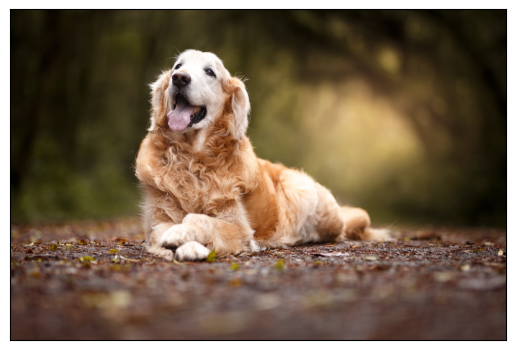

In [30]:
img = Image.open(input_img)

fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

print(f'Predicted class: {"cat" if pred["predicted_class"] == 0 else "dog"}')

# AlexNet

In [24]:
alex_net = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), 
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), 
    nn.BatchNorm2d(384),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), 
    nn.BatchNorm2d(384),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), 
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.6),

    nn.Linear(4096, 2)
)

alex_net

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, mom

In [25]:
def train_model(model, criterion, optimizer, scheduler, epochs=50, patience=5, device='cpu'):
    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
        'epoch_time': []
    }
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100.0 * train_correct / train_total

        # validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
                
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100.0 * val_correct / val_total

        scheduler.step(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['lr'].append(current_lr)
        
        # print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print("-" * 60)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_alexnet_model.pth')
        else:
            counter += 1
            print(f'No improvement for {counter} epochs.')
            
            if counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load('best_alexnet_model.pth'))
    
    return model, history

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex_net.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

alex_net_best_model, history = train_model(alex_net, criterion, optimizer, scheduler, epochs=10, patience=3, device='cuda')

Epoch 1/10
Train Loss: 0.6929, Train Acc: 56.00%
Val Loss: 0.6297, Val Acc: 64.27%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6583, Train Acc: 61.56%
Val Loss: 0.5969, Val Acc: 69.27%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.6330, Train Acc: 64.41%
Val Loss: 0.5954, Val Acc: 67.52%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.6056, Train Acc: 67.79%
Val Loss: 0.5392, Val Acc: 73.52%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.5758, Train Acc: 70.03%
Val Loss: 0.4810, Val Acc: 77.14%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.5361, Train Acc: 73.19%
Val Loss: 0.8391, Val Acc: 61.90%
Learning Rate: 0.000010
-----------------------------------------------------

C:\Users\joao_\AppData\Local\Temp\ipykernel_24264\1366415877.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_alexnet_model.pth'))

In [30]:
def inference(model, image, transform=None, device='cpu'):
    model.to(device)
    model.eval()

    if isinstance(image, str):
        image = Image.open(image).convert('RGB')

    if not isinstance(image, torch.Tensor):
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        image = transform(image)

    if image.dim() == 3:
        image = image.unsqueeze(0)

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item(), probabilities[0]

Predicted class: cat
Class probabilities: tensor([0.7041, 0.2959])


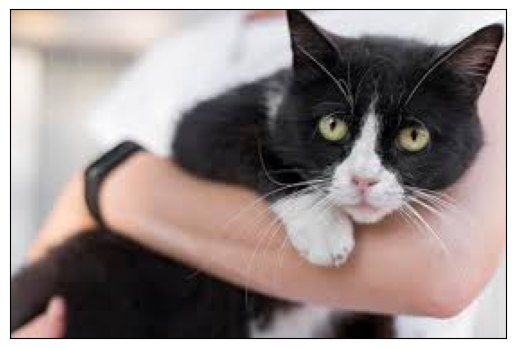

In [37]:
img = Image.open(r"C:\Users\joao_\Downloads\images (1).jpg")

fig = plt.imshow(img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

pred_class, probs = inference(alex_net_best_model, img)
print(f'Predicted class: {"cat" if pred_class == 0 else "dog"}')
print(f'Class probabilities: {probs}')